In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
!pip install datasets

In [ ]:
import gdown

!gdown --id 1_8Fp31El2D1M_BKLp2lr1xWHV8NY-8Xi

In [43]:
# class ImageNetTiny(Dataset):
#     def __init__(self, root, txt, train = True, transform = None):
#         self.root = Path(root)
#         self.train = train
#         self.transform = transform
#         self.labels =  Path(txt).open().readlines()
#         self.labels = [x.strip() for x in self.labels]
#         labels = []
#         for x in tqdm(self.labels):
#             image_name, image_label = x.split(" ")
#             image_path = self.root / "image" / image_name
#             if not image_path.exists(): continue
#             labels.append((image_path, image_label))
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.labels)
#     def __getitem__(self, idx):
#         image_path, _ = self.labels[idx]
#         image = Image.open(image_path)
#         if self.transform:
#             image = self.transform(image)
#         return image


In [32]:
class ImageNetTiny(Dataset):
    def __init__(self, root, txt, train = True, transform = None):
        self.root = Path(root)
        self.train = train
        self.transform = transform
        self.labels =  Path(txt).open().readlines()
        self.labels = [x.strip() for x in self.labels]
        labels = []
        for x in tqdm(self.labels):
            image_path, image_label = x.split(" ")
            image_path = self.root / image_path
            if not image_path.exists(): continue
            labels.append((image_path, image_label))
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path, _ = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image


In [92]:
import torch
from torch import nn

class AutoEncoder_v2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                    nn.Conv2d(3, 16, 3, padding='same'),
                    nn.ReLU(),
                    # # nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    # # # nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 8, 3,  stride=2),
                    # nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(392, 128),
                    nn.Linear(128, 64),
                    nn.Linear(64, 72),

                )
        self.decoder = nn.Sequential(
                    nn.Unflatten(1, (8, 3, 3)),
                    nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(16, 32, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 3, 4, stride=2, padding=0),
                    nn.Sigmoid()
                    # nn.Tanh()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [33]:
from random import shuffle
import math

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
original_batch_size = 64
batch_size = 128
original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)

root = "data/TinyImageNet"

train_txt = "data/TinyImageNet/train.txt"
train_dataset = ImageNetTiny(root, train_txt, train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_txt = "data/TinyImageNet/val.txt"
val_dataset = ImageNetTiny(root, train_txt, transform)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:01<00:00, 58016.97it/s]


In [95]:
from tqdm import tqdm 
device = torch.device("cuda:0")
model = AutoEncoder_v2().to(device)
original_lr = 0.001
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, data in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data in bar_eval:
                data = data.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

  0%|          | 0/196 [00:00<?]

[TRAIN]:Epoch 39 Loss 0.0303: 100%|██████████| 196/196 [00:20<00:00]


In [108]:
from tqdm import tqdm 
# increase learning to 0.01, original was 0.001
device = torch.device("cuda:0")
model = AutoEncoder_v2().to(device)
original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, data in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data in bar_eval:
                data = data.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

[TRAIN]:Epoch 39 Loss 0.0224: 100%|██████████| 196/196 [00:20<00:00]


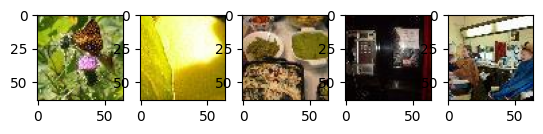

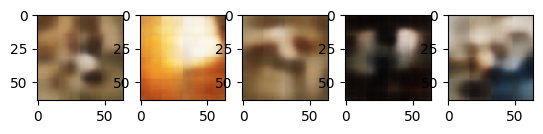

In [109]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(64,64,3)
        ax[i].imshow(z_)
    plt.show()

data_ = data.cpu().numpy()
data_ = data_.transpose(0, 2, 3, 1)
output_ = output.detach().cpu().numpy()
output_ = output_.transpose(0, 2, 3, 1)
plotn(5,data_[0:5])
plotn(5,output_[0:5])

In [90]:
# encoder = nn.Sequential(
#                     nn.Conv2d(3, 16, 3, padding='same'),
#                     nn.ReLU(),
#                     # # nn.MaxPool2d(2, 2),
#                     nn.Conv2d(16, 16, 3, stride=2),
#                     nn.ReLU(),
#                     nn.Conv2d(16, 16, 3, stride=2),
#                     nn.ReLU(),
#                     # # # nn.MaxPool2d(2, 2),
#                     nn.Conv2d(16, 8, 3,  stride=2),
#                     # nn.ReLU(),
#                     nn.Flatten(),
#                     nn.Linear(392, 128),
#                     nn.Linear(128, 64),
#                     nn.Linear(64, 72),

#                 )
# # hout = (input - 1) * stride - 2 * padding + kernel_size
# decoder = nn.Sequential(
#             nn.Unflatten(1, (8, 3, 3)),
#             nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 32, 3, stride=2, padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 3, 4, stride=2, padding=0),
#             # nn.Tanh()
#         )
# out_encoder = encoder(torch.randn(5, 3, 64, 64))
# print(out_encoder.shape)
# out_decoder = decoder(out_encoder)
# print(out_decoder.shape)

torch.Size([5, 72])
torch.Size([5, 3, 64, 64])


In [115]:
from tqdm import tqdm 
# increase learning to 0.01, original was 0.001
# init weight with xavier uniform
device = torch.device("cuda:0")
model = AutoEncoder_v2().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, data in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data in bar_eval:
                data = data.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

/tmp/ipykernel_1387101/1890943542.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
[TRAIN]:Epoch 39 Loss 0.0214: 100%|██████████| 196/196 [00:21<00:00]


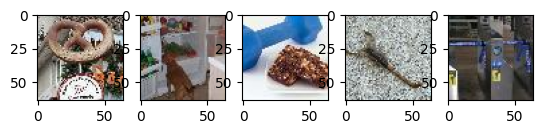

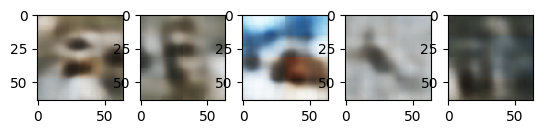

In [116]:
data_ = data.cpu().numpy()
data_ = data_.transpose(0, 2, 3, 1)
output_ = output.detach().cpu().numpy()
output_ = output_.transpose(0, 2, 3, 1)
plotn(5,data_[0:5])
plotn(5,output_[0:5])

In [266]:
class AutoEncoder_v3(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                    nn.Conv2d(3, 16, 3, padding='same'),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    nn.Conv2d(16, 8, 3,  stride=2),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(392, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 72),

                )
        self.decoder = nn.Sequential(
                    nn.Unflatten(1, (8, 3, 3)),
                    nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(16, 32, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 3, 4, stride=2, padding=0),
                    nn.Sigmoid()
                    # nn.Tanh()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [267]:
from tqdm import tqdm 
# add relu to encoder
# init weight with xavier uniform
device = torch.device("cuda:0")
model = AutoEncoder_v3().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, data in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data in bar_eval:
                data = data.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

/tmp/ipykernel_1387101/3001509557.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
  0%|          | 0/196 [00:00<?]

[TRAIN]:Epoch 13 Loss 0.0349:  76%|███████▌  | 149/196 [00:15<00:04]

In [36]:
# add  more layer --> resulted in failure
# dont know why, MNIST have low resolution, grayscale, and lot less image
# tiny imagenet have high resolution, color, and lot more image
# then the model should be more complex by adding more layer
# then why should it fail?

from torch import nn

class AutoEncoder_V4(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
        out_encoder = self.encoder(torch.randn(6, 3, 64, 64))
        print(out_encoder.shape)
        out_decoder = self.decoder(out_encoder)
        print(out_decoder.shape)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
class ImageNetTiny(Dataset):
    def __init__(self, root, txt, train = True, transform = None):
        self.root = Path(root)
        self.train = train
        self.transform = transform
        self.labels =  Path(txt).open().readlines()
        self.labels = [x.strip() for x in self.labels]
        labels = []
        for x in tqdm(self.labels):
            image_name, image_label = x.split(" ")
            image_path = self.root / "image" / image_name
            if not image_path.exists(): continue
            labels.append((image_path, image_label))
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image_path, _ = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image


In [34]:
from random import shuffle
import math

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
original_batch_size = 64
batch_size = 512
original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
train_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/train/")
train_txt = train_root / "train.txt"
train_set = ImageNetTiny(root = train_root, txt = train_txt, transform = transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/val/")
test_txt = test_root / "val.txt"
test_set = ImageNetTiny(root = test_root, txt = test_txt, transform = transform)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

100%|██████████| 10000/10000 [00:02<00:00, 3821.90it/s]


In [37]:
from tqdm import tqdm
import math 
# add relu to encoder
# init weight with xavier uniform
device = torch.device("cuda:0")
model = AutoEncoder_V4().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, data in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data in bar_eval:
                data = data.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

torch.Size([6, 64, 7, 7])
torch.Size([6, 3, 64, 64])


[TRAIN]:Epoch 39 Loss 0.0069: 100%|██████████| 196/196 [00:20<00:00]


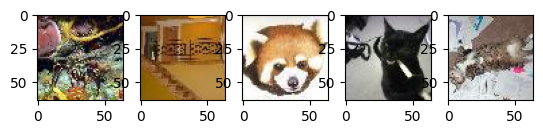

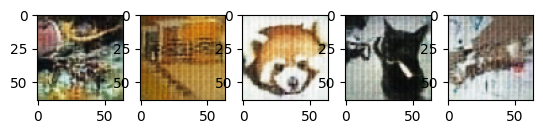

In [39]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(64,64,3)
        ax[i].imshow(z_)
    plt.show()
data_ = data.cpu().numpy()
data_ = data_.transpose(0, 2, 3, 1)
output_ = output.detach().cpu().numpy()
output_ = output_.transpose(0, 2, 3, 1)
plotn(5,data_[0:5])
plotn(5,output_[0:5])

# Denoise

In [58]:
import numpy as np
data = np.random.randn(64,64)
data_noise = np.random.normal(loc=0.5,scale=0.5,size=data.shape)
print(data.shape,data_noise.shape)

(64, 64) (64, 64)


In [85]:
torch.FloatTensor(64,64).uniform_(0., 1.0)

tensor([[0.3177, 0.6577, 0.9248,  ..., 0.1070, 0.3891, 0.4234],
        [0.2255, 0.5921, 0.9624,  ..., 0.8438, 0.4735, 0.4683],
        [0.7218, 0.3785, 0.6444,  ..., 0.3362, 0.4104, 0.5285],
        ...,
        [0.2844, 0.6900, 0.1097,  ..., 0.4251, 0.6580, 0.6491],
        [0.0066, 0.0771, 0.0580,  ..., 0.2343, 0.6558, 0.1646],
        [0.9853, 0.5176, 0.5376,  ..., 0.6900, 0.3451, 0.1515]])

In [4]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F


class MyMNIST(datasets.MNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        # print(img.shape)
        img_noise = torch.clip(img + torch.FloatTensor(img.shape).uniform_(0.25, 0.75), 0. , 1.)
        # img_noise = transforms.ToPILImage()(img_noise)
        # img = self.transform(img)
        # img_noise = self.transform(img_noise)
        return img, img_noise

from torch.utils.data import DataLoader



transform=transforms.Compose([
    transforms.ToTensor(),
    ])
dataset1 = MyMNIST('./data', train=True, download=True, transform=transform)

dataset2 = MyMNIST('./data', train=False, transform=transform)
batch_size = 64
train_loader = DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
for batch_idx, (data, data_noise) in enumerate(bar):
    # print(data.shape)
    print(data.shape, data_noise.shape, data.dtype, data_noise.dtype)
    break

  0%|          | 0/938 [00:01<?]

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28]) torch.float32 torch.float32


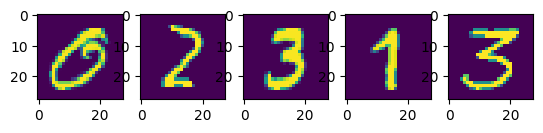

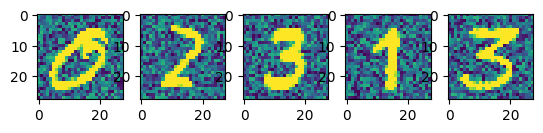

In [5]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(28,28,1)
        ax[i].imshow(z_)
    plt.show()
plotn(5,data[0:5])
plotn(5,data_noise[0:5])

In [21]:
torch.FloatTensor(5,5).uniform_(-0.25, 0.25)

tensor([[-0.0377, -0.1012,  0.2468, -0.0084, -0.0608],
        [-0.1131, -0.2133,  0.2362,  0.0660,  0.2116],
        [-0.2435,  0.1612, -0.1443, -0.1894,  0.1635],
        [ 0.0100,  0.1214, -0.2371,  0.2109,  0.1012],
        [-0.1853, -0.0105, -0.2283, -0.0534,  0.0113]])

In [26]:
class ImageNetTiny_noise(Dataset):
    def __init__(self, root, txt, train = True, transform = None):
        self.root = Path(root)
        self.train = train
        self.transform = transform
        self.labels =  Path(txt).open().readlines()
        self.labels = [x.strip() for x in self.labels]
        labels = []
        for x in tqdm(self.labels):
            image_name, image_label = x.split(" ")
            image_path = self.root / "image" / image_name
            if not image_path.exists(): continue
            labels.append((image_path, image_label))
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image_path, _ = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
            # range from 0.25 to 0.75 is mess up
            # -0.05, 0.05 not change very much in original ima
            
            img_noise = torch.clip(image + torch.FloatTensor(image.shape).uniform_(-0.15, 0.15), 0. , 1.)
        return image, img_noise


In [27]:
from random import shuffle
import math

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
original_batch_size = 64
batch_size = 512
original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
train_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/train/")
train_txt = train_root / "train.txt"
train_set = ImageNetTiny_noise(root = train_root, txt = train_txt, transform = transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/val/")
test_txt = test_root / "val.txt"
test_set = ImageNetTiny_noise(root = test_root, txt = test_txt, transform = transform)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3830.77it/s]


In [9]:
bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
for batch_idx, (data, data_noise) in enumerate(bar):
    # print(data.shape)
    print(data.shape, data_noise.shape, data.dtype, data_noise.dtype)
    break

  0%|          | 0/196 [00:00<?]

torch.Size([512, 3, 64, 64]) torch.Size([512, 3, 64, 64]) torch.float32 torch.float32


  0%|          | 0/196 [00:01<?]


In [12]:
from torch import nn

class AutoEncoder_V4_noise(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
from tqdm import tqdm
import math 
# add relu to encoder
# init weight with xavier uniform
device = torch.device("cuda:0")
model = AutoEncoder_V4_noise().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data, data_noise) in enumerate(bar):
        data = data.to(device)
        data_noise = data_noise.to(device)
        optimizer.zero_grad()
        output = model(data_noise)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data, data_noise in bar_eval:
                data = data.to(device)
                data_noise = data_noise.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

[TRAIN]:Epoch 39 Loss 0.0099: 100%|██████████| 196/196 [00:26<00:00]


  0%|          | 0/20 [00:01<?]


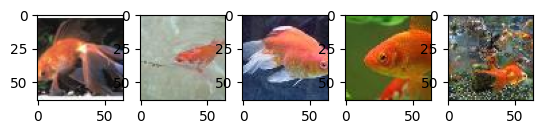

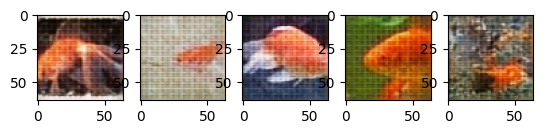

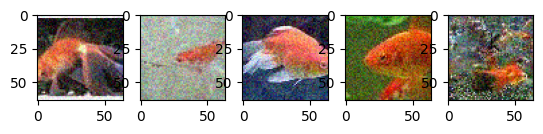

In [29]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(64,64,3)
        ax[i].imshow(z_)
    plt.show()
    
bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
with torch.no_grad():
    for data, data_noise in bar_eval:
        data = data.to(device)
        data_noise = data_noise.to(device)
        output = model(data)
        break  
data_ = data.cpu().numpy()
data_ = data_.transpose(0, 2, 3, 1)
output_ = output.detach().cpu().numpy()
output_ = output_.transpose(0, 2, 3, 1)
data_noise_ = data_noise.detach().cpu().numpy()
data_noise_ = data_noise_.transpose(0, 2, 3, 1)
plotn(5,data_[0:5])
plotn(5,output_[0:5])
plotn(5,data_noise_[0:5])

# Upscale

In [51]:
from torch import nn

class AutoEncoder_V4_upscale(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 16, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(16, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 64, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64, 3, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


encoder = nn.Sequential(
                nn.Conv2d(3, 16, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(16, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 64, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64, 3, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )

out_encoder = encoder(torch.randn(5, 3, 32, 32))
print(out_encoder.shape)
out_decoder = decoder(out_encoder)
print(out_decoder.shape)

torch.Size([5, 64, 1, 1])
torch.Size([5, 3, 64, 64])


In [44]:
class ImageNetTiny_upscale(Dataset):
    def __init__(self, root, txt, train = True):
        self.root = Path(root)
        self.train = train
        self.transform = transforms.Compose([
                transforms.Lambda(lambda x: x.convert("RGB")),
                transforms.Resize((64, 64)),
                transforms.ToTensor()
            ])
        self.labels =  Path(txt).open().readlines()
        self.labels = [x.strip() for x in self.labels]
        labels = []
        for x in tqdm(self.labels):
            image_name, image_label = x.split(" ")
            image_path = self.root / "image" / image_name
            if not image_path.exists(): continue
            labels.append((image_path, image_label))
        self.labels = labels
        
        self.transform_half = transforms.Compose([
                transforms.Lambda(lambda x: x.convert("RGB")),
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ])
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image_path, _ = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image_ori = self.transform(image)
            # range from 0.25 to 0.75 is mess up
            # -0.05, 0.05 not change very much in original ima
            
            # img_noise = torch.clip(image + torch.FloatTensor(image.shape).uniform_(-0.15, 0.15), 0. , 1.)
        if self.transform_half:
            img_half = self.transform_half(image)
        return image_ori, img_half
from random import shuffle
import math

tch_size = 64
batch_size = 512
original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
train_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/train/")
train_txt = train_root / "train.txt"
train_set = ImageNetTiny_upscale(root = train_root, txt = train_txt)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_root = Path("/mlcv2/WorkingSpace/Personal/hienht/lsd_c/tiny-imagenet/val/")
test_txt = test_root / "val.txt"
test_set = ImageNetTiny_upscale(root = test_root, txt = test_txt)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

100%|██████████| 10000/10000 [00:02<00:00, 3876.05it/s]


In [58]:
from tqdm import tqdm
import math 
# add relu to encoder
# init weight with xavier uniform
device = torch.device("cuda:0")
model = AutoEncoder_V4_upscale().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

original_lr = 0.01
lr = original_lr * math.sqrt(original_batch_size / batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epoch = 40
eval_every = 5
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data_ori, data_half) in enumerate(bar):
        data_ori = data_ori.to(device)
        data_half = data_half.to(device)
        optimizer.zero_grad()
        output = model(data_half)
        loss = F.mse_loss(output, data_ori)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data_ori, data_half in bar_eval:
                data_ori = data_ori.to(device)
                data_half = data_half.to(device)
                output = model(data_half)
                loss = F.mse_loss(output, data_ori)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

[TRAIN]:Epoch 39 Loss 0.0212: 100%|██████████| 196/196 [00:26<00:00]


In [59]:
with torch.no_grad():
    for data_ori, data_half in bar_eval:
        data_ori = data_ori.to(device)
        data_half = data_half.to(device)
        output = model(data_half)
        loss = F.mse_loss(output, data_ori)
        bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        break

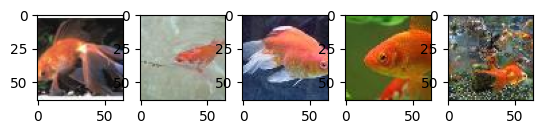

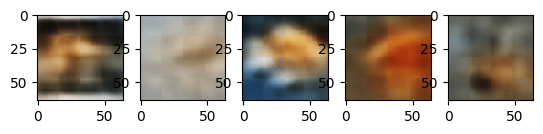

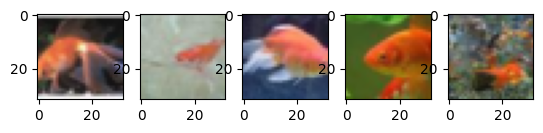

In [61]:
data_ = data_ori.cpu().numpy()
data_ = data_.transpose(0, 2, 3, 1)
output_ = output.detach().cpu().numpy()
output_ = output_.transpose(0, 2, 3, 1)
data_half_ = data_half.detach().cpu().numpy()
data_half_ = data_half_.transpose(0, 2, 3, 1)
plotn(5,data_[0:5])
plotn(5,output_[0:5])


def plotn_(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(32,32,3)
        ax[i].imshow(z_)
    plt.show()
plotn_(5,data_half_[0:5])